# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pylab
import pytrip as pt
import copy
import matplotlib as mpl

In [2]:
from matplotlib import colors, cm
from numpy import ma
from pytrip.volhist import VolHist 
from itertools import cycle
cycol = cycle('bgrcmk')

In [3]:
style_param = {'legend.fontsize': '20',
         'xtick.direction' : 'in',  
         'ytick.direction' : 'in', 
         'xtick.top' : True, 
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
pylab.rcParams.update(style_param)

# Functions

### Prescribed dose and number of fractionation

In [4]:
## Choose alpha/beta ratio == 2.0 or 10.0
dose_pres = 55.8 
fraction=31.
dose_per_fr=dose_pres/fraction
ab=2.
bins=256

In [5]:
def rbe_wedenberg(dose, let, abx,q):
    """
    Wedenberg proton RBE model
    input parameters may be either numpy.array or scalars
    TODO: handle Cube() class directly
    :params dose: physical proton dose in [Gy]
    :params let: LETd in [keV/um] (protons only)
    :params abx: alpha_x / beta_x [Gy]
    :returns: RBE for the given parameters
    :ref: http://dx.doi.org/10.3109/0284186X.2012.705892
    """

    _apx = 1.000 + q * let / abx
    _sbpx = 1.0

    rbe = _rbe_apx(dose, _apx, _sbpx, abx)
    return rbe

In [6]:
def _rbe_apx(dose, apx, sbpx, abx, dzero=0.0):
    """
    :params dose: proton dose      [Gy]
    :params apx: alpha_p / alpha_x [dimensionless] RBE_max = ap/ax when (dose -> 0 Gy)
    :params sbpx: beta_p / beta_x  [dimensionless] RBE_min = sqrt(bp/bx) when (dose -> inf Gy)
    :params abx: alpha_x / beta_x  [Gy]
    :params dzero: what to return in case of dose is zero (which would cause division by zero)
    """

    _rbe = 1.0 / (2.0 * dose)
    if hasattr(_rbe, '__iter__'):
        _rbe[_rbe == np.inf] = dzero
    else:
        if _rbe == np.inf:
            return dzero
    delta = abx * abx + 4. * abx * apx * dose + 4. * sbpx * sbpx * dose * dose
    delta *= (delta > 0)
    _rbe *= (np.sqrt(delta) - abx)
    return _rbe

In [7]:
def biological_dose (q,ab,dos_cube,let_cube):
    result = pt.DosCube()
    result.cube = rbe_wedenberg(dos_cube.cube, let_cube.cube, ab, q) * dos_cube.cube
    return result

In [8]:
def calculate_dvh (qval,mask,dose_cube,let_cube, ab=ab,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr):
    
    biol_dose= rbe_wedenberg(dose=dose_cube.cube[mask], let=let_cube.cube[mask], abx=ab, q=qval) * dose_cube.cube[mask]

    _xrange = (0.0,2.4)
    _hist, x = np.histogram((biol_dose), bins=1024, range=_xrange,density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)    

In [9]:
def plot_dvh ( dose_cube, bins ): 

    _hist, x = np.histogram(dose_cube, bins=bins, density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)    

In [10]:
def plot_dvh_xrange ( dose_cube,bins = 1024):
   
    _xrange=(0,2.4)
    _hist, x = np.histogram(dose_cube, bins=bins,range=_xrange, density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)  

In [11]:
def read_DoseCube(path_patient):
    
#Cube with Dose in Patient
    dos_cube = pt.DosCube()
    dos_cube.read(path_patient)
    dos_cube.cube = dos_cube.cube.astype(np.float64)
    dos_cube.cube /= 1000.0
    dos_cube.cube *= dose_per_fr/1.1
#Cube with LET in Patient
    let_cube = pt.LETCube()
    let_cube.read(path_patient)

    return(dos_cube,let_cube)

# Read data

In [12]:
#read q-parameter data
open_fname = os.path.join('tmp','distrib_q.h5')
df_q = pd.read_hdf(open_fname, 'data_1')      #df_q

In [13]:
#mean q value with 85% CI
mean_W, std_W = 0.434, 0.0301
mean_WB, down_WB, up_WB = df_q.q.mean(), df_q.q.quantile(0.075), df_q.q.quantile(0.925)

In [14]:
df_q.q.quantile(0.075), df_q.q.mean() - 1.44*df_q.q.std()

(0.35494444740813963, 0.3523450007082325)

In [15]:
#original plan from CCB
path_ct = os.path.join('data','patient_simulation','ct','inspire07pancreas')
path_patient_org = os.path.join('data','patient_simulation','plan1','inspire07pancreas')
#modyfied plan (5 degrees)
path_patient_mod = os.path.join('data','patient_simulation','plan2','inspire07pancreas')

# Patient: PyTrip Data

In [16]:
#CT data for patient
ctx_cube = pt.CtxCube()
ctx_cube.read(path_ct)
vdx_cube = pt.VdxCube(ctx_cube)
vdx_cube.read(path_ct+'.vdx')

In [17]:
##First Oryginal Plan
dos_cube , let_cube = read_DoseCube(path_patient_org)
##Second Plam
dos_cube2 , let_cube2 = read_DoseCube(path_patient_mod)

In [18]:
# index of point in original plan with highest dose
imax = np.unravel_index(dos_cube.cube.argmax(), dos_cube.cube.shape)

## Contour Organs

In [19]:
print(vdx_cube.voi_names())

['duodenum', 'kidney_L', 'kidney_R', 'liver', 'pancreas', 'spleen', 'Spinalcord', 'stomach', 'iCTV_5040', 'iCTV_5580', 'Ref', 'External']


In [20]:
organ_names ='kidney_L', 'kidney_R', 'liver', 'pancreas', 'Spinalcord', 'stomach', 'iCTV_5580'
organ_names_PL= 'lewa nerka', 'prawa nerka', 'wątroba', 'trzustka', 'rdzeń kręgowy', 'brzuch', 'CTV'

In [21]:
def contour_data_cm(organ_name):
    # pytrip stores all contour data in [mm] units
    pytrip_contour_data_mm = vdx_cube.get_voi_by_name(organ_name).get_slice_at_pos(ctx_cube.slice_pos[imax[0]]).contours[0].contour
    x_contour_data_cm = [item[0] / 10. for item in pytrip_contour_data_mm]
    y_contour_data_cm = [item[1] / 10. for item in pytrip_contour_data_mm]

    return x_contour_data_cm, y_contour_data_cm

In [22]:
df_organs=pd.DataFrame()
for organ in organ_names:
    df_organs[organ] = contour_data_cm(organ)    

# Visualization dose in patient for two plans

In [23]:
#Change pixels to cm
image_extent_cm = [
    ctx_cube.xoffset/10,ctx_cube.xoffset/10 + ctx_cube.dimx*dos_cube.pixel_size/10.,
    ctx_cube.yoffset/10,ctx_cube.yoffset/10 + ctx_cube.dimy*dos_cube.pixel_size/10.
    ]

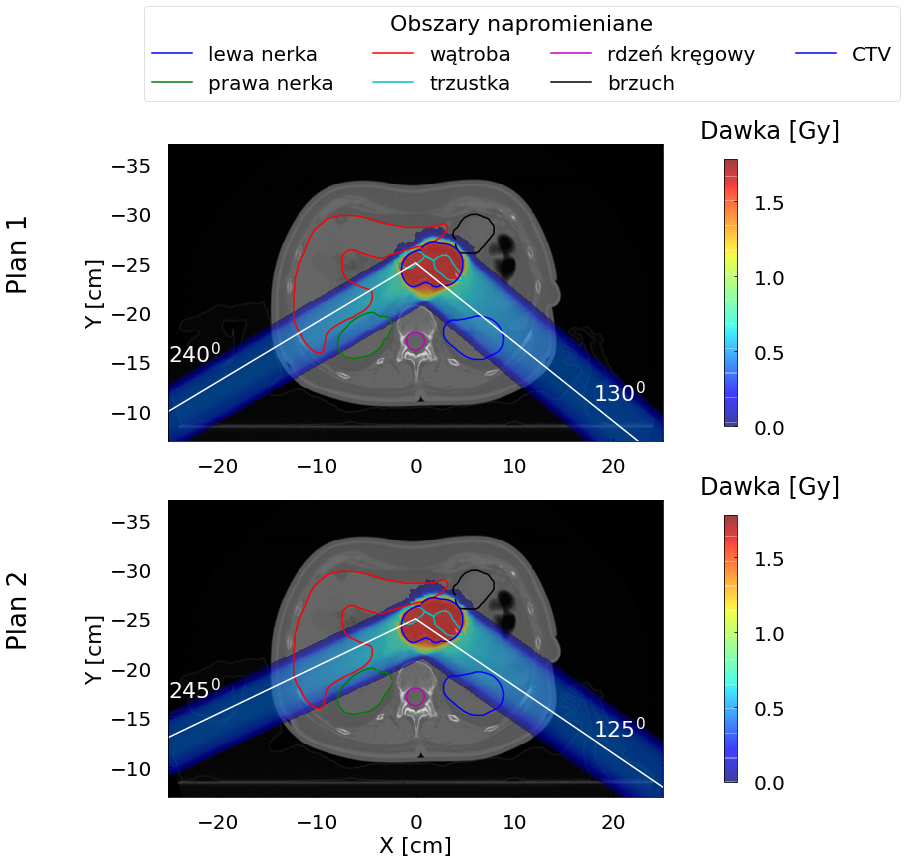

In [24]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,12))

#Choose colors for dose
cmap1 =  copy.copy(mpl.cm.get_cmap("jet"))
cmap1.set_under("k", alpha=0.0) 
cmap1.set_over("k", alpha=0.0)
cmap1.set_bad("k", alpha=0.0) 

#Plot CT
im11=ax1.imshow(ctx_cube.cube[imax[0],:,:], cmap=plt.cm.gray, interpolation='nearest', origin="lower",extent=image_extent_cm)
im22=ax2.imshow(ctx_cube.cube[imax[0],:,:],cmap=plt.cm.gray,interpolation='nearest', origin="lower",extent=image_extent_cm)

#Plot Dose

im1=ax1.imshow(ma.masked_where(dos_cube.cube[imax[0],:,:] <= dos_cube.cube.min(), dos_cube.cube[imax[0],:,:]),
    cmap=cmap1,norm=colors.Normalize(vmin=0, vmax = dos_cube.cube.max() * 1.1, clip=False),
    alpha=0.5,interpolation='nearest', origin="lower", extent=image_extent_cm)

im2=ax2.imshow(ma.masked_where(dos_cube2.cube[imax[0],:,:] <= dos_cube2.cube.min(), dos_cube2.cube[imax[0],:,:]),
    cmap=cmap1,norm=colors.Normalize(vmin=0, vmax=dos_cube2.cube.max() * 1.1, clip=False),
    alpha=0.5,interpolation='nearest',origin="lower",extent=image_extent_cm)

#Plot organs contours

for organ,organ_PL in zip(df_organs.columns.values,organ_names_PL,):
    color=next(cycol)
    ax1.plot(df_organs[organ][0],df_organs[organ][1], c=color,label = organ_PL)
    ax2.plot(df_organs[organ][0],df_organs[organ][1], c=color, label = organ_PL)

#gantry angle
ax1.plot([-25, 0], [-10,-25], 'w-')
ax1.text(-25,-15, r'$240^0$',fontsize=22, color='w')
ax1.plot([0,25], [-25,-5], 'w-')
ax1.text(18,-11, r'$130^0$',fontsize=22, color='w')

ax2.plot([-25, 0], [-13,-25], 'w-')
ax2.text(-25,-17, r'$245^0$',fontsize=22, color='w')
ax2.plot([0,25], [-25,-8], 'w-')
ax2.text(18,-13, r'$125^0$',fontsize=22, color='w')


#Plotting info
ax1.legend(title = "Obszary napromieniane",loc='best',bbox_to_anchor=(1.5 , 1.5),fancybox=True, framealpha=0.6, title_fontsize=22,ncol=4)
ax1.set_title('Plan 1', rotation='vertical',x=-0.3,y=0.5,fontsize=26)
ax2.set_title('Plan 2', rotation='vertical',x=-0.3,y=0.5,fontsize=26)
ax1.set_ylabel('Y [cm]',fontsize=22)
ax2.set_xlabel('X [cm]',fontsize=22)
ax2.set_ylabel('Y [cm]',fontsize=22)

ax1.set_ylim(-37,-7)
ax2.set_ylim(-37,-7)
ax1.invert_yaxis()
ax2.invert_yaxis()


#colorbar
fig.colorbar(im1, ax=ax1, label ="Dawka [Gy]", shrink = 0.9).set_label(label="Dawka [Gy]", size=24, labelpad=-15, y=1.15, rotation=0)
fig.colorbar(im2, ax=ax2, label ="Dawka [Gy]", shrink = 0.9 ).set_label(label="Dawka [Gy]", size=24, labelpad=-15, y=1.15, rotation=0)

# Dose and LET for Plan 1

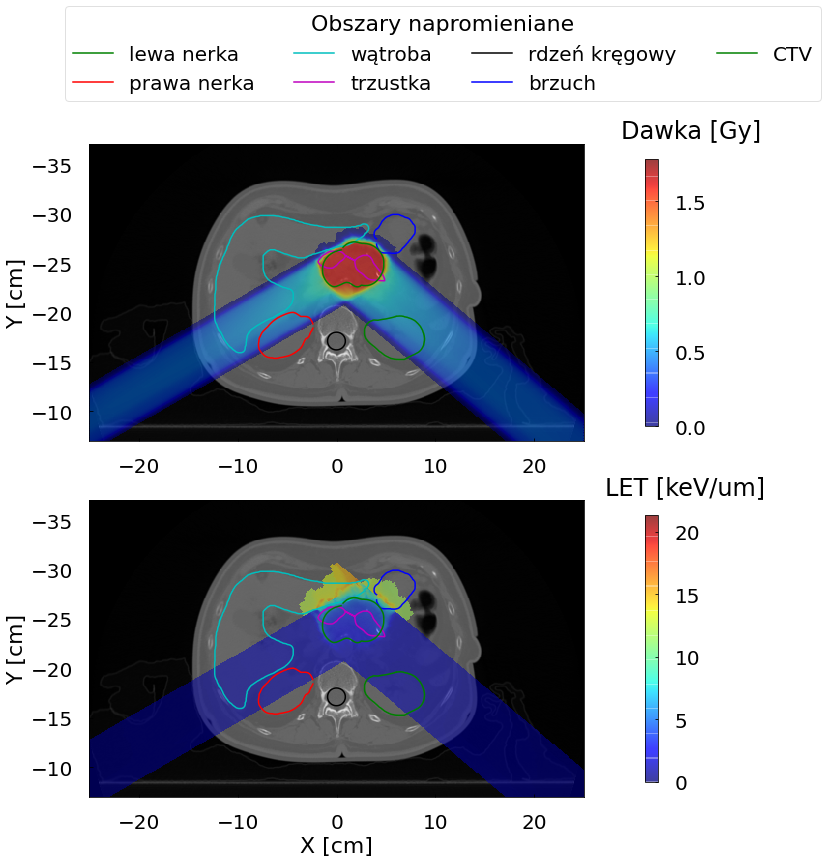

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,12))

#Choose colors for dose
cmap1 =  copy.copy(mpl.cm.get_cmap("jet"))
cmap1.set_under("k", alpha=0.0) 
cmap1.set_over("k", alpha=0.0)
cmap1.set_bad("k", alpha=0.0) 

#Plot CT
im11=ax1.imshow(ctx_cube.cube[imax[0],:,:], cmap=plt.cm.gray, interpolation='nearest', origin="lower",extent=image_extent_cm)
im22=ax2.imshow(ctx_cube.cube[imax[0],:,:],cmap=plt.cm.gray,interpolation='nearest', origin="lower",extent=image_extent_cm)

#Plot Dose

im1=ax1.imshow(ma.masked_where(dos_cube.cube[imax[0],:,:] <= dos_cube.cube.min(), dos_cube.cube[imax[0],:,:]),
    cmap=cmap1,norm=colors.Normalize(vmin=0, vmax = dos_cube.cube.max() * 1.1, clip=False),
    alpha=0.5,interpolation='nearest', origin="lower", extent=image_extent_cm)

im2=ax2.imshow(ma.masked_where(let_cube.cube[imax[0],:,:] <= let_cube.cube.min(), let_cube.cube[imax[0],:,:]),
    cmap=cmap1,norm=colors.Normalize(vmin=0, vmax=let_cube.cube.max() * 1.1, clip=False),
    alpha=0.5,interpolation='nearest',origin="lower",extent=image_extent_cm)

#Plot organs contours

for organ,organ_PL in zip(df_organs.columns.values,organ_names_PL,):
    color=next(cycol)
    ax1.plot(df_organs[organ][0],df_organs[organ][1], c=color,label = organ_PL)
    ax2.plot(df_organs[organ][0],df_organs[organ][1], c=color, label = organ_PL)


#Plotting info
ax1.legend(title = "Obszary napromieniane",loc='best',bbox_to_anchor=(1.5 , 1.5),fancybox=True, framealpha=0.6, title_fontsize=22,ncol=4)
#ax1.set_title('Plan 1', rotation='vertical',x=-0.3,y=0.5,fontsize=26)
#ax2.set_title('Plan 2', rotation='vertical',x=-0.3,y=0.5,fontsize=26)
ax1.set_ylabel('Y [cm]',fontsize=22)
ax2.set_xlabel('X [cm]',fontsize=22)
ax2.set_ylabel('Y [cm]',fontsize=22)

ax1.set_ylim(-37,-7)
ax2.set_ylim(-37,-7)
ax1.invert_yaxis()
ax2.invert_yaxis()


#colorbar
fig.colorbar(im1, ax=ax1, label ="Dawka [Gy]", shrink = 0.9).set_label(label="Dawka [Gy]", size=24, labelpad=-15, y=1.15, rotation=0)
fig.colorbar(im2, ax=ax2, label ="LET [keV/um]", shrink = 0.9 ).set_label(label="LET [keV/um]", size=24, labelpad=-15, y=1.15, rotation=0)

In [26]:
biol_dos=(rbe_wedenberg(dos_cube.cube[imax[0],:,:],let_cube.cube[imax[0],:,:],ab,mean_WB)*dos_cube.cube[imax[0],:,:])
biol_dos_down=(rbe_wedenberg(dos_cube.cube[imax[0],:,:],let_cube.cube[imax[0],:,:],ab,down_WB)*dos_cube.cube[imax[0],:,:])
biol_dos_up=(rbe_wedenberg(dos_cube.cube[imax[0],:,:],let_cube.cube[imax[0],:,:],ab,up_WB)*dos_cube.cube[imax[0],:,:])

<ipython-input-6-e65464a2caee>:10: RuntimeWarning: divide by zero encountered in true_divide
  _rbe = 1.0 / (2.0 * dose)


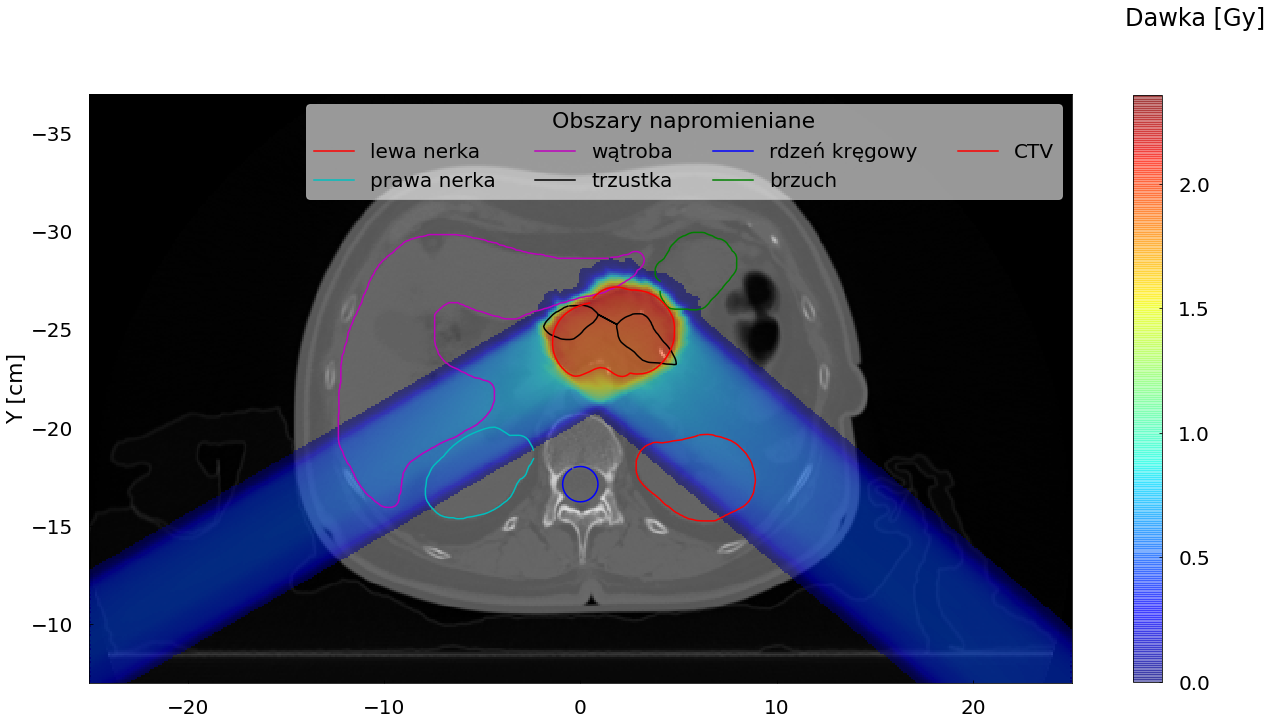

In [27]:
fig, ax1 = plt.subplots(1,1, figsize=(22,12))

#Choose colors for dose
cmap1 =  copy.copy(mpl.cm.get_cmap("jet"))
cmap1.set_under("k", alpha=0.0) 
cmap1.set_over("k", alpha=0.0)
cmap1.set_bad("k", alpha=0.0) 

#Plot CT
im11=ax1.imshow(ctx_cube.cube[imax[0],:,:], cmap=plt.cm.gray, interpolation='nearest', origin="lower",extent=image_extent_cm)

#Plot Dose

im1=ax1.imshow(ma.masked_where(biol_dos <= biol_dos.min(), biol_dos),
    cmap=cmap1,norm=colors.Normalize(vmin=0, vmax = biol_dos.max() * 1.1, clip=False),
    alpha=0.5,interpolation='nearest', origin="lower", extent=image_extent_cm)


#Plot organs contours
for organ,organ_PL in zip(df_organs.columns.values,organ_names_PL,):
    color=next(cycol)
    ax1.plot(df_organs[organ][0],df_organs[organ][1], c=color,label = organ_PL)

#Plotting info
ax1.legend(title = "Obszary napromieniane",loc='best',bbox_to_anchor=(1. , 1.),fancybox=True, framealpha=0.6, title_fontsize=22,ncol=4)
ax1.set_ylabel('Y [cm]',fontsize=22)
ax1.set_ylim(-37,-7)
ax1.invert_yaxis()

#colorbar
fig.colorbar(im1, ax=ax1, label ="Dawka [Gy]", shrink = 0.9).set_label(label="Dawka [Gy]", size=24, labelpad=-15, y=1.15, rotation=0)


# Uncetainties RBE for Wedenberg and Wedenberg B transversal sections axis X


In [28]:
x_cm = np.linspace(start = ctx_cube.xoffset/10, stop=ctx_cube.xoffset/10 + ctx_cube.dimx*dos_cube.pixel_size/10., num = ctx_cube.dimx)

In [29]:
y_cm = np.linspace(start = ctx_cube.yoffset/10, stop=ctx_cube.yoffset/10 + ctx_cube.dimy*dos_cube.pixel_size/10., num = ctx_cube.dimy)

In [30]:
def biological_dose(mean, quantile_down, quantile_up):

    #Uncetainties of biological dose for Wedenberg for model
    dose,let=dos_cube.cube[imax[0],imax[1],:],let_cube.cube[imax[0],imax[1],:]

    biol_dose=rbe_wedenberg(dose,let,ab,mean)*dose
    biol_dose_down=rbe_wedenberg(dose,let,ab,quantile_down)*dose
    biol_dose_up=rbe_wedenberg(dose,let,ab,quantile_up)*dose
            
    return biol_dose,biol_dose_down,biol_dose_up

In [31]:
#Uncetainties of biological dose for Wedenberg for model
biol_dose_W,biol_dose_down_W,biol_dose_up_W = biological_dose(mean_W, mean_W-1.44*std_W,  mean_W+1.44*std_W)
#Uncetainties of biological dose for Wedenberg B for model
biol_dose_WB,biol_dose_down_WB,biol_dose_up_WB = biological_dose(mean_WB, down_WB, up_WB)

<ipython-input-6-e65464a2caee>:10: RuntimeWarning: divide by zero encountered in true_divide
  _rbe = 1.0 / (2.0 * dose)


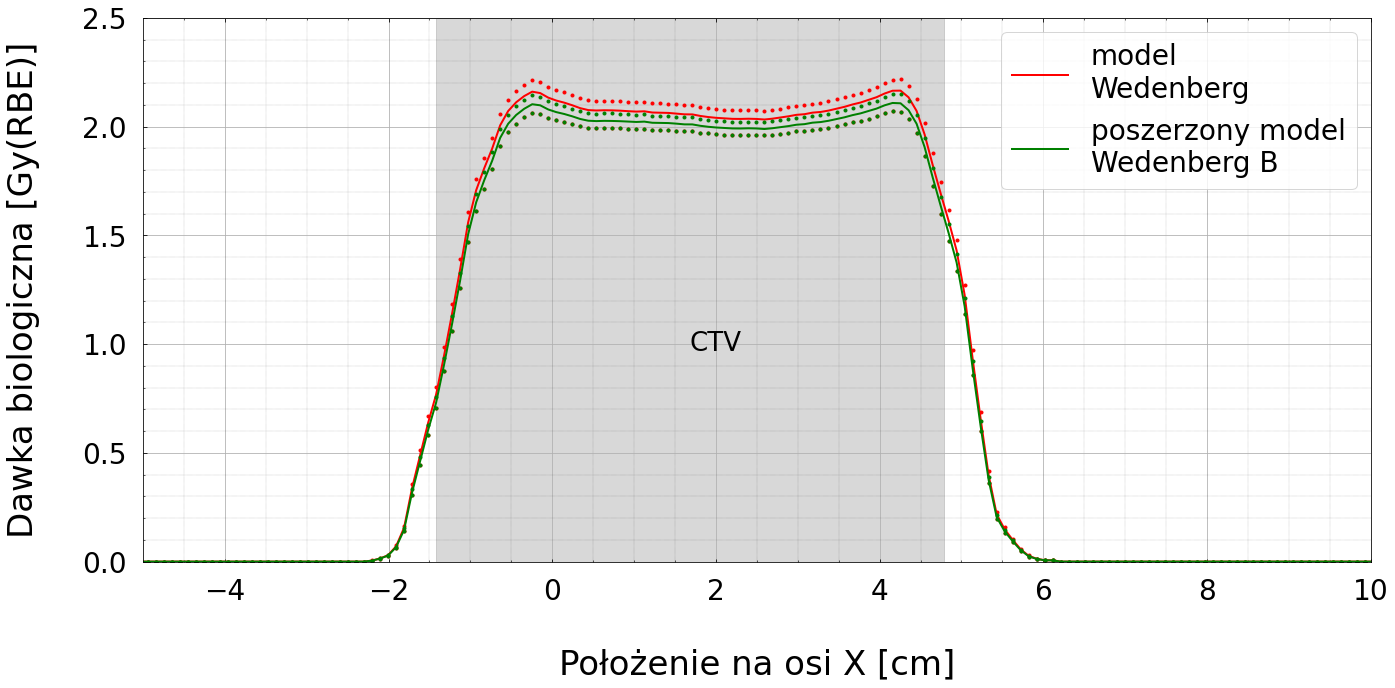

In [32]:
#Biological Dose 
plt.figure(figsize=(22,10))

plt.plot(x_cm, biol_dose_W,'r', linewidth=2., label = "model\nWedenberg")
plt.plot(x_cm, biol_dose_up_W,'r.', linewidth=2.)
plt.plot(x_cm, biol_dose_down_WB,'r.', linewidth=2.)

plt.plot(x_cm,biol_dose_WB,'g', linewidth=2., label = "poszerzony model\nWedenberg B")
plt.plot(x_cm,biol_dose_up_WB,'g.', linewidth=2.)
plt.plot(x_cm,biol_dose_down_WB,'g.', linewidth=2.)

#CTV area 
#axvspan
plt.axvspan(min(df_organs['iCTV_5580'][0]),max(df_organs['iCTV_5580'][0]), color='gray', alpha=0.3)
plt.text(2, 1, 'CTV', horizontalalignment='center',verticalalignment='center',size=26)

plt.ylabel("Dawka biologiczna [Gy(RBE)]\n", fontsize = 34)
plt.xlabel("\nPołożenie na osi X [cm]", fontsize = 34)
plt.legend(loc = "upper right",  fontsize = 28)

plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)

plt.xlim(-5,10)
plt.ylim(0,2.5)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in' 
plt.rcParams['xtick.top'] = True 
plt.rcParams['ytick.right'] = True

In [33]:
def uncertainty_of_dose(mean_dose, up_dose):
    uncertainty = (up_dose - mean_dose) / mean_dose*100
    uncertainty[np.isnan(uncertainty)] = 0
    return uncertainty

In [34]:
def uncertainty_of_dose_v2(mean_dose, down_dose):
    uncertainty = ( mean_dose-down_dose) / mean_dose*100
    uncertainty[np.isnan(uncertainty)] = 0    
    return uncertainty

In [35]:
y_uncertainty_W = uncertainty_of_dose(np.array(biol_dose_W),np.array(biol_dose_up_W))
y_uncertainty_WB = uncertainty_of_dose(np.array(biol_dose_WB),np.array(biol_dose_up_WB))

<ipython-input-33-201608e9570e>:2: RuntimeWarning: invalid value encountered in true_divide
  uncertainty = (up_dose - mean_dose) / mean_dose*100


In [36]:
y_uncertainty_WB_v2 = uncertainty_of_dose_v2(np.array(biol_dose_WB),np.array(biol_dose_down_WB))

<ipython-input-34-5eaf141df3df>:2: RuntimeWarning: invalid value encountered in true_divide
  uncertainty = ( mean_dose-down_dose) / mean_dose*100


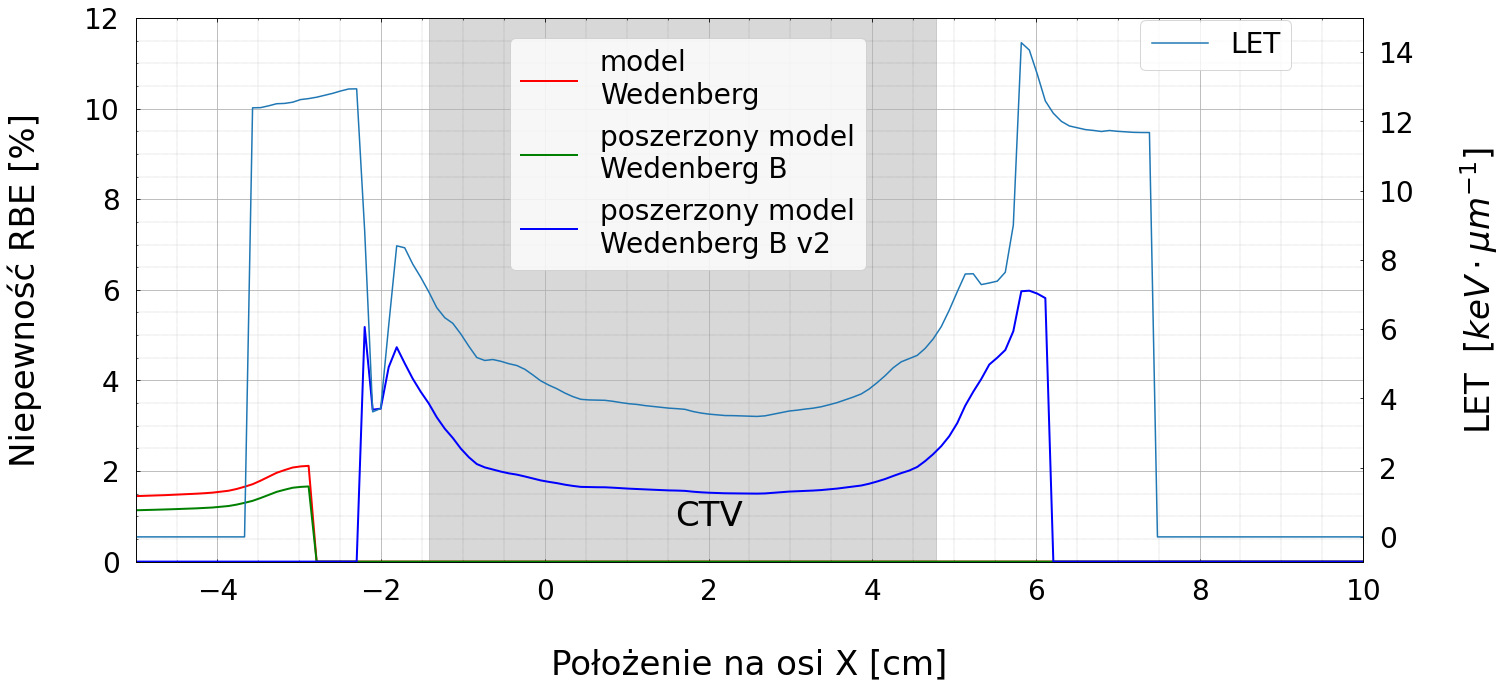

In [76]:
#Uncetainties RBE for Wedenberg model
fig,ax = plt.subplots(figsize=[22,10])

ax2=ax.twinx()
ax.plot(x_cm,y_uncertainty_W ,'r', linewidth=2., label = "model\nWedenberg")
ax.plot(x_cm,y_uncertainty_WB,'g', linewidth=2., label = "poszerzony model\nWedenberg B")
ax.plot(x_cm,y_uncertainty_WB_v2,'b', linewidth=2., label = "poszerzony model\nWedenberg B v2")

ax2.plot(x_cm, let_cube.cube[imax[0],imax[1],:], label='LET')

ax.axvspan(min(df_organs['iCTV_5580'][0]),max(df_organs['iCTV_5580'][0]), color='gray', alpha=0.3)
ax.text(2, 1, 'CTV', horizontalalignment='center',verticalalignment='center',size=34)

ax.set_ylabel("Niepewność RBE [%]\n", fontsize = 34)
ax.set_xlabel("\nPołożenie na osi X [cm]", fontsize = 34)
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",size=34,rotation=90)

ax.set_xlim(-5,10)
ax.set_ylim(0,12)

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major', labelsize=28)
ax2.tick_params(axis='both', which='major', labelsize=28)


ax.legend(loc="center",bbox_to_anchor=(0.45, 0.75), borderaxespad=0.,fontsize=28)
ax2.legend(loc="center",bbox_to_anchor=(0.88, 0.95), borderaxespad=0.,fontsize=28)

# Uncetainties RBE for Wedenberg and Wedenberg B transversal sections axis YTODO

In [38]:
def biological_dose(mean, quantile_down, quantile_up):

    #Uncetainties of biological dose for Wedenberg for model
    biol_dose,biol_dose_up,biol_dose_down=[],[],[]

    for dose, let in zip(dos_cube.cube[imax[0],:,imax[2]],let_cube.cube[imax[0],:,imax[2]]):
        if dose>0:
            biol_dose.append(rbe_wedenberg(dose,let,ab,mean)*dose)
            biol_dose_down.append(rbe_wedenberg(dose,let,ab,quantile_down)*dose)
            biol_dose_up.append(rbe_wedenberg(dose,let,ab,quantile_up)*dose)

        else:
            biol_dose.append(0)
            biol_dose_down.append(0)
            biol_dose_up.append(0)
            
    return biol_dose,biol_dose_up,biol_dose_down

In [39]:
#Uncetainties of biological dose for Wedenberg for model
biol_dose_W,biol_dose_up_W,biol_dose_down_W = biological_dose(mean_W, mean_W-1.44*std_W,  mean_W+1.44*std_W)
#Uncetainties of biological dose for Wedenberg B for model
biol_dose_WB,biol_dose_up_WB,biol_dose_down_WB = biological_dose(mean_WB,down_WB,up_WB)

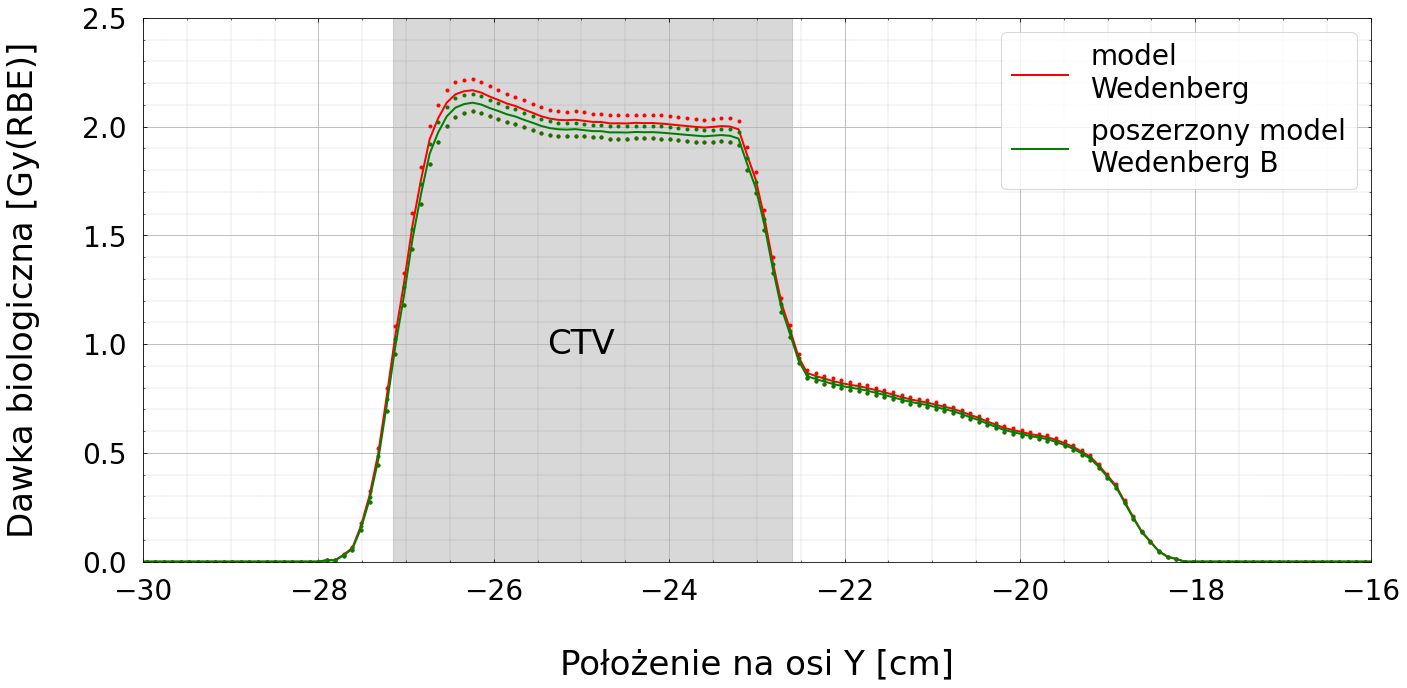

In [40]:
#Biological Dose for Wedenberg model
plt.figure(figsize=(22,10))

plt.plot(y_cm, biol_dose_W,'r', linewidth=2., label = "model\nWedenberg")
plt.plot(y_cm, biol_dose_up_W,'r.', linewidth=2.)
plt.plot(y_cm, biol_dose_down_WB,'r.', linewidth=2.)

plt.plot(y_cm,biol_dose_WB,'g', linewidth=2., label = "poszerzony model\nWedenberg B")
plt.plot(y_cm,biol_dose_up_WB,'g.', linewidth=2.)
plt.plot(y_cm,biol_dose_down_WB,'g.', linewidth=2.)

plt.axvspan(min(df_organs['iCTV_5580'][1]),max(df_organs['iCTV_5580'][1]), color='gray', alpha=0.3)
plt.text(-25, 1, 'CTV', horizontalalignment='center',verticalalignment='center',size=34)

plt.ylabel("Dawka biologiczna [Gy(RBE)]\n", fontsize = 34)
plt.xlabel("\nPołożenie na osi Y [cm]", fontsize = 34)
plt.legend(loc = "best",  fontsize = 28)

plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)

plt.xlim(-30,-16)
plt.ylim(0,2.5)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in' 
plt.rcParams['xtick.top'] = True 
plt.rcParams['ytick.right'] = True

In [41]:
y_uncertainty_W = uncertainty_of_dose(np.array(biol_dose_W),np.array(biol_dose_up_W))
y_uncertainty_WB = uncertainty_of_dose(np.array(biol_dose_WB),np.array(biol_dose_up_WB))

<ipython-input-33-201608e9570e>:2: RuntimeWarning: invalid value encountered in true_divide
  uncertainty = (up_dose - mean_dose) / mean_dose*100


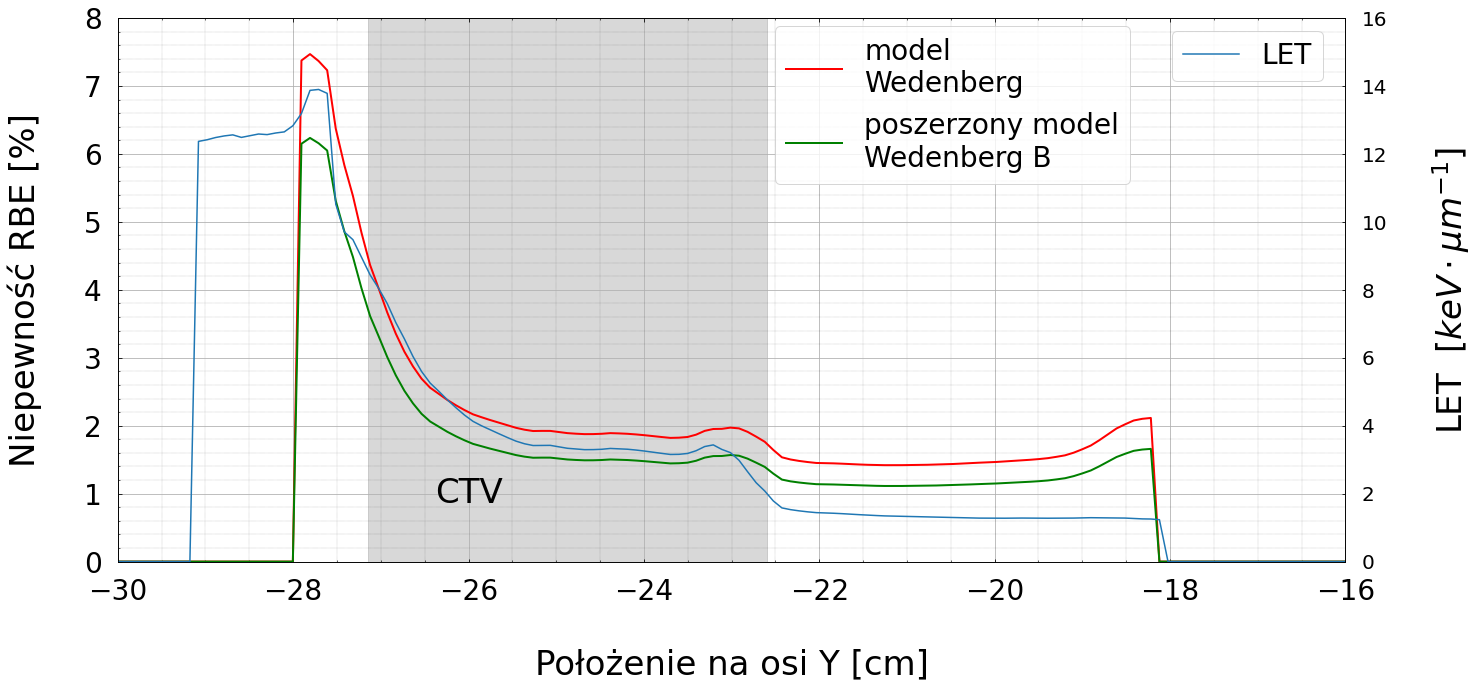

In [75]:
#Uncetainties RBE for Wedenberg model
fig,ax = plt.subplots(figsize=[22,10])

ax2=ax.twinx()
ax.plot(y_cm,y_uncertainty_W ,'r', linewidth=2., label = "model\nWedenberg")
ax.plot(y_cm,y_uncertainty_WB,'g', linewidth=2., label = "poszerzony model\nWedenberg B")
ax2.plot(y_cm, let_cube.cube[imax[0],:,imax[2]], label='LET')

ax.axvspan(min(df_organs['iCTV_5580'][1]),max(df_organs['iCTV_5580'][1]), color='gray', alpha=0.3)
ax.text(-26, 1, 'CTV', horizontalalignment='center',verticalalignment='center',size=34)

ax.set_ylabel("Niepewność RBE [%]\n", fontsize = 34)
ax.set_xlabel("\nPołożenie na osi Y [cm]", fontsize = 34)
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",size=34,rotation=90)

ax.set_xlim(-30,-16)
ax.set_ylim(0,8)
ax2.set_ylim(0,16)

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major', labelsize=28)

ax.legend(loc="center",bbox_to_anchor=(0.68, 0.84), borderaxespad=0.,fontsize=28)
ax2.legend(loc="center",bbox_to_anchor=(0.92, 0.93), borderaxespad=0.,fontsize=28)

# DVH - volume_histogram() function

In [43]:
#Clinical model: factor 1.1 : Plan 1 i 2
#normalization for 1.8 Gy 
dvh_clinical = VolHist.volume_histogram(dos_cube.cube,voi=vdx_cube.get_voi_by_name('iCTV_5580'),bins=256)
dvh2_clinical = VolHist.volume_histogram(dos_cube2.cube,voi=vdx_cube.get_voi_by_name('iCTV_5580'),bins=256)

In [44]:
# static volume_histogram(data_cube, voi=None, bins=256)
dvh = VolHist(dos_cube,voi=vdx_cube.get_voi_by_name('iCTV_5580')).volume_histogram(dos_cube.cube,voi=vdx_cube.get_voi_by_name('iCTV_5580'),bins=256)
dvh2 = VolHist(dos_cube2,voi=vdx_cube.get_voi_by_name('iCTV_5580')).volume_histogram(dos_cube2.cube,voi=vdx_cube.get_voi_by_name('iCTV_5580'),bins=256)   #inna metoda

# Biological Dose

In [45]:
organ_names =   'liver', 'pancreas', 'spleen', 'Spinalcord',  'iCTV_5580',
organ_names_PL= 'wątroba', 'trzustka','śledziona','rdzeń kręgowy',  'CTV'

In [46]:
#calculate sooo long
dvh_wedB = dict()
dvh_wedB["Plan1"] = dict()
dvh_wedB["Plan2"] = dict()

for organ in organ_names:
    target_voi = vdx_cube.get_voi_by_name(organ)
    voi_cube = target_voi.get_voi_cube()
    mask = (voi_cube.cube == 1000)
    
    dvh_wedB["Plan1"][organ] = dict()
    dvh_wedB["Plan1"][organ]["mean"] = calculate_dvh(qval=mean_WB,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
    dvh_wedB["Plan1"][organ]["down"] = calculate_dvh(qval=down_WB,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
    dvh_wedB["Plan1"][organ]["up"] = calculate_dvh(qval=up_WB,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
    
    dvh_wedB["Plan2"][organ] = dict()
    dvh_wedB["Plan2"][organ]["mean"] = calculate_dvh(qval=mean_WB,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)
    dvh_wedB["Plan2"][organ]["down"] = calculate_dvh(qval=down_WB,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)
    dvh_wedB["Plan2"][organ]["up"] = calculate_dvh(qval=up_WB,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)

<ipython-input-6-e65464a2caee>:10: RuntimeWarning: divide by zero encountered in true_divide
  _rbe = 1.0 / (2.0 * dose)


In [57]:
dvh_wed = dict()
dvh_wed["Plan1"] = dict()
dvh_wed["Plan2"] = dict()

for organ in organ_names:
    
    target_voi = vdx_cube.get_voi_by_name(organ)
    voi_cube = target_voi.get_voi_cube()
    mask = (voi_cube.cube == 1000)
    
    dvh_wed["Plan1"][organ] = dict()
    dvh_wed["Plan2"][organ] = dict()

    #if organ == 'iCTV_5580':
    dvh_wed["Plan1"][organ]["mean"] = calculate_dvh(qval=mean_W,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
    dvh_wed["Plan1"][organ]["down"] =calculate_dvh(qval=mean_W-1.44*std_W,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
    dvh_wed["Plan1"][organ]["up"] = calculate_dvh(qval=mean_W+1.44*std_W,mask=mask,dose_cube=dos_cube,let_cube=let_cube)
        
    dvh_wed["Plan2"][organ]["mean"] = calculate_dvh(qval=mean_W,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)
    dvh_wed["Plan2"][organ]["down"] =calculate_dvh(qval=mean_W-1.44*std_W,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)
    dvh_wed["Plan2"][organ]["up"] = calculate_dvh(qval=mean_W+1.44*std_W,mask=mask,dose_cube=dos_cube2,let_cube=let_cube2)
   

<ipython-input-6-e65464a2caee>:10: RuntimeWarning: divide by zero encountered in true_divide
  _rbe = 1.0 / (2.0 * dose)


(0.0, 2.4)

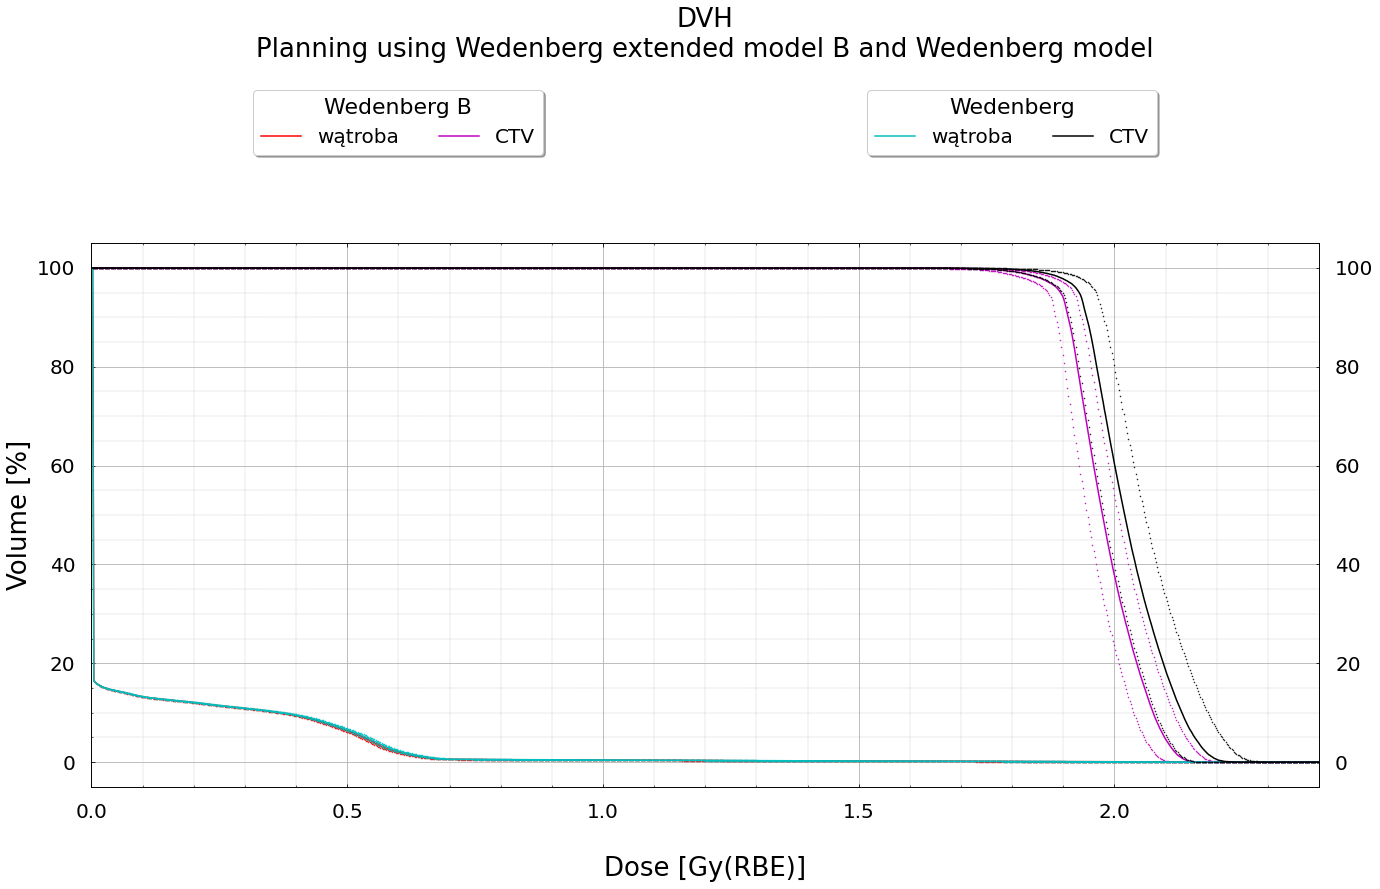

In [59]:
organ_names_ = ['liver','iCTV_5580']
organ_names_PL_ = ['wątroba','CTV']
#Plan 1 for Wedenberg and WedenbergB models

fig,ax = plt.subplots(figsize=[22,10])
ax2=ax.twinx()

##Plan 1
for organ,organ_PL in zip(organ_names_,organ_names_PL_):
#WedenbergB
    col=next(cycol)
    ax.plot(dvh_wedB["Plan1"][organ]['mean'][0],dvh_wedB["Plan1"][organ]['mean'][1],c=col, label = organ_PL)
    ax.plot(dvh_wedB["Plan1"][organ]['up'][0],dvh_wedB["Plan1"][organ]['up'][1],".",c=col,markersize=1)
    ax.plot(dvh_wedB["Plan1"][organ]['down'][0],dvh_wedB["Plan1"][organ]['down'][1],".",c=col,markersize=1)
#Wedenberg 
    col=next(cycol)
    ax2.plot(dvh_wed["Plan1"][organ]['mean'][0],dvh_wed["Plan1"][organ]['mean'][1],c=col, label = organ_PL)
    ax2.plot(dvh_wed["Plan1"][organ]['up'][0],dvh_wed["Plan1"][organ]['up'][1],".",c=col,markersize=1)
    ax2.plot(dvh_wed["Plan1"][organ]['down'][0],dvh_wed["Plan1"][organ]['down'][1],".",c=col,markersize=1)



##graph settings
ax.set_title("DVH\nPlanning using Wedenberg extended model B and Wedenberg model\n\n\n\n\n\n")
ax.set_ylabel("Volume [%]")
ax.set_xlabel("\nDose [Gy(RBE)]")

ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax.get_legend().set_title("Wedenberg B")
ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax2.get_legend().set_title("Wedenberg")

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

ax.set_xlim(0,2.4)
ax2.set_xlim(0,2.4)

(0.0, 2.4)

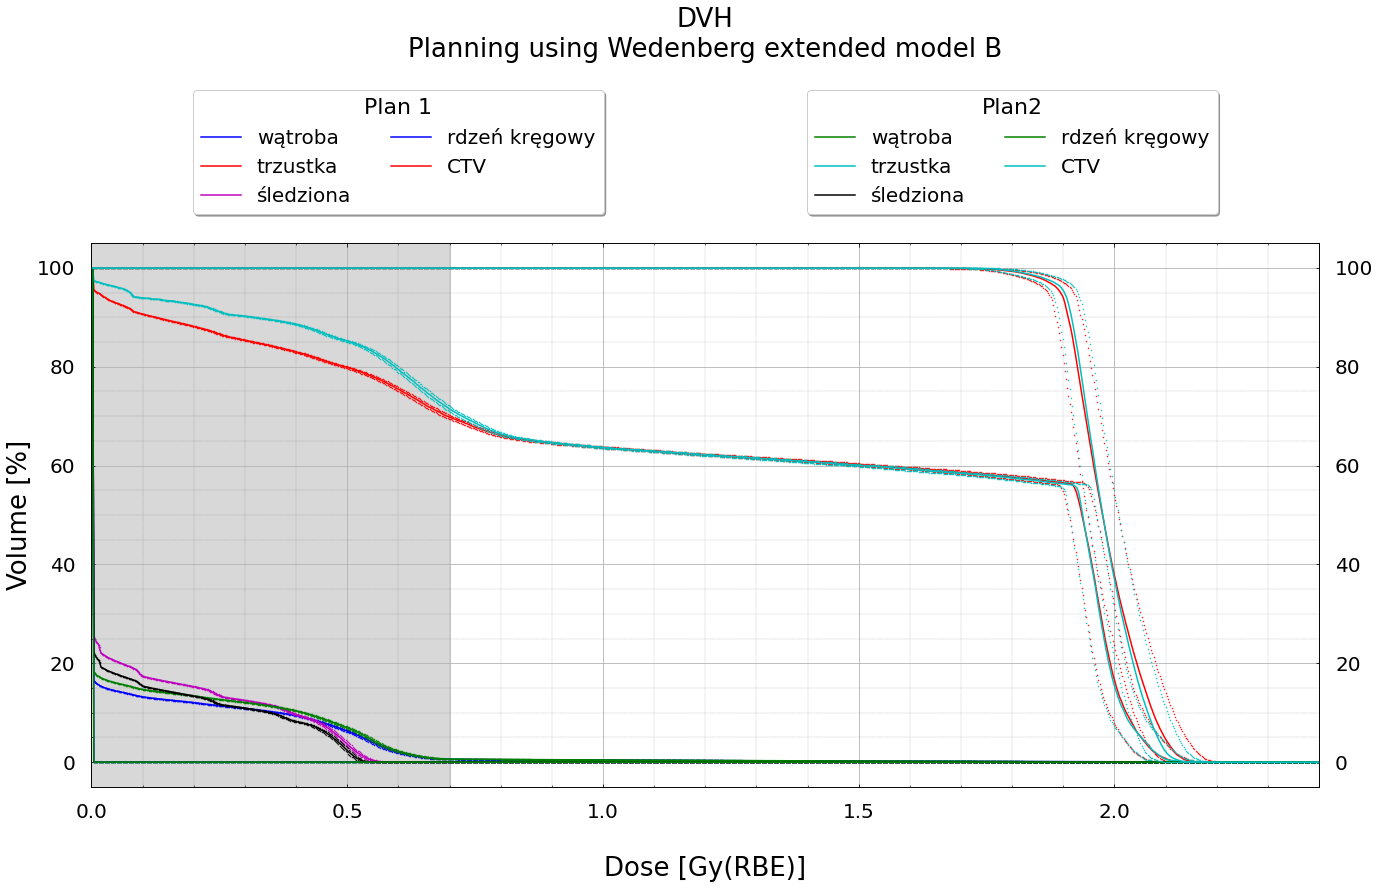

In [67]:
#Compare two plans for WedenbergB model

fig,ax = plt.subplots(figsize=[22,10])
ax2=ax.twinx()
##Plan 1
for organ,organ_PL in zip(organ_names,organ_names_PL):    
    col=next(cycol)
    ax.plot(dvh_wedB["Plan1"][organ]['mean'][0],dvh_wedB["Plan1"][organ]['mean'][1],c=col, label = organ_PL)
    ax.plot(dvh_wedB["Plan1"][organ]['up'][0],dvh_wedB["Plan1"][organ]['up'][1],".",c=col,markersize=1)
    ax.plot(dvh_wedB["Plan1"][organ]['down'][0],dvh_wedB["Plan1"][organ]['down'][1],".",c=col,markersize=1)
#Plan 2
    col=next(cycol)
    ax2.plot(dvh_wedB["Plan2"][organ]['mean'][0],dvh_wedB["Plan2"][organ]['mean'][1],c=col, label = organ_PL)
    ax2.plot(dvh_wedB["Plan2"][organ]['up'][0],dvh_wedB["Plan2"][organ]['up'][1],".",c=col,markersize=1)
    ax2.plot(dvh_wedB["Plan2"][organ]['down'][0],dvh_wedB["Plan2"][organ]['down'][1],".",c=col,markersize=1)

##graph settings
ax.set_title("DVH\nPlanning using Wedenberg extended model B\n\n\n\n\n\n")
ax.set_ylabel("Volume [%]")
ax.set_xlabel("\nDose [Gy(RBE)]")

#plt.xlim(1.5,2.2)
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax.get_legend().set_title("Plan 1")

ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax2.get_legend().set_title("Plan2")

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
ax.axvspan(0,0.7, alpha=0.3, color='gray')

ax.set_xlim(0,2.4)
ax2.set_xlim(0,2.4)

(0.0, 20.0)

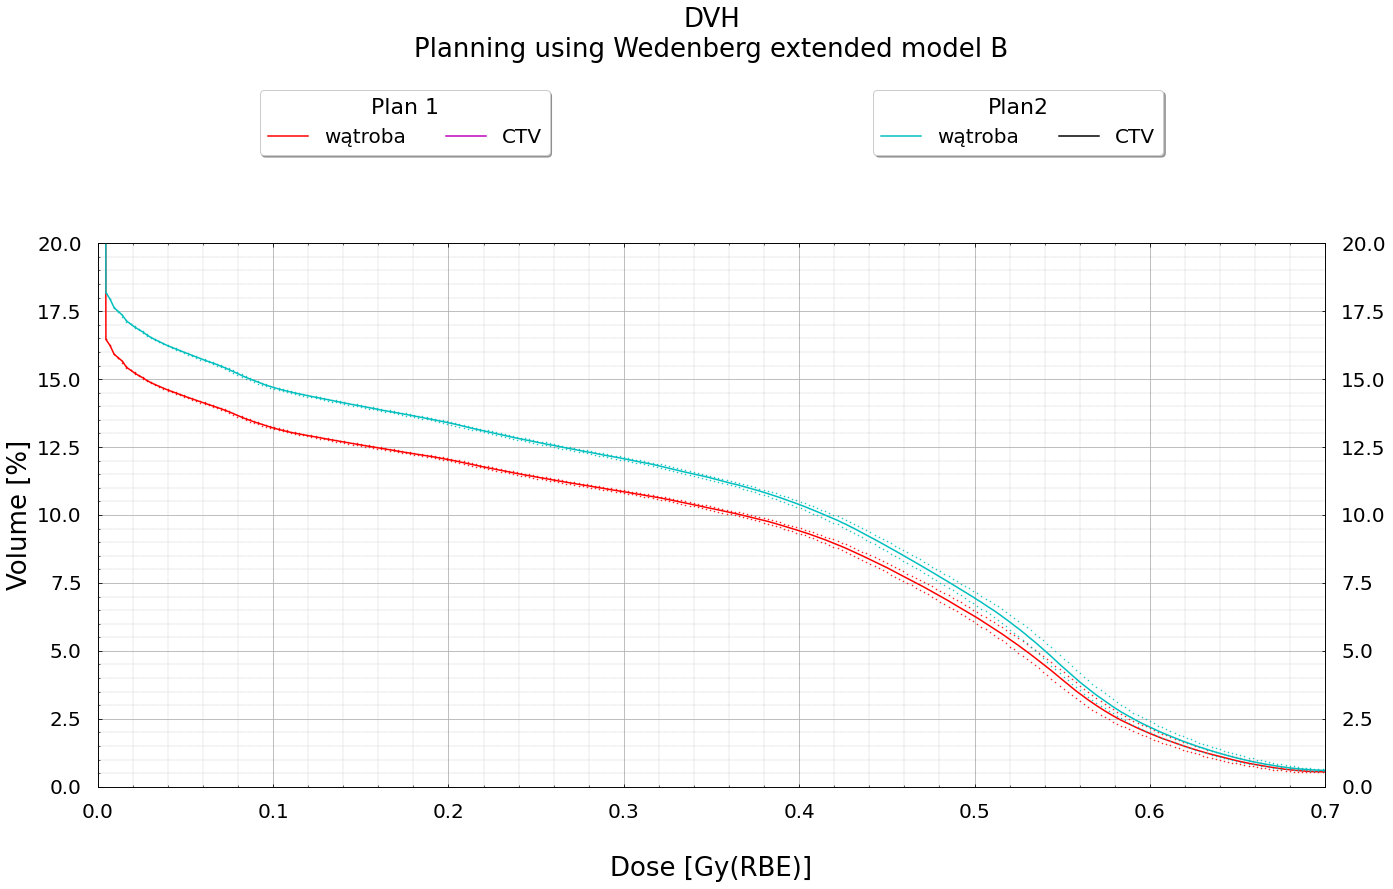

In [69]:
#Compare two plans for WedenbergB model zoom

fig,ax = plt.subplots(figsize=[22,10])
ax2=ax.twinx()

##Plan 1
for organ,organ_PL in zip(organ_names_,organ_names_PL_):
    col=next(cycol)
    ax.plot(dvh_wedB["Plan1"][organ]['mean'][0],dvh_wedB["Plan1"][organ]['mean'][1],c=col, label = organ_PL)
    ax.plot(dvh_wedB["Plan1"][organ]['up'][0],dvh_wedB["Plan1"][organ]['up'][1],".",c=col,markersize=1)
    ax.plot(dvh_wedB["Plan1"][organ]['down'][0],dvh_wedB["Plan1"][organ]['down'][1],".",c=col,markersize=1)
#Plan 2
    col=next(cycol)
    ax2.plot(dvh_wedB["Plan2"][organ]['mean'][0],dvh_wedB["Plan2"][organ]['mean'][1],c=col, label = organ_PL)
    ax2.plot(dvh_wedB["Plan2"][organ]['up'][0],dvh_wedB["Plan2"][organ]['up'][1],".",c=col,markersize=1)
    ax2.plot(dvh_wedB["Plan2"][organ]['down'][0],dvh_wedB["Plan2"][organ]['down'][1],".",c=col,markersize=1)

##graph settings
ax.set_title("DVH\nPlanning using Wedenberg extended model B\n\n\n\n\n\n")
ax.set_ylabel("Volume [%]")
ax.set_xlabel("\nDose [Gy(RBE)]")

#plt.xlim(1.5,2.2)
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax.get_legend().set_title("Plan 1")

ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3),title_fontsize=22,fancybox=True, shadow=True,ncol=2)
ax2.get_legend().set_title("Plan2")

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')


ax.set_xlim(0,0.7)
ax2.set_xlim(0,0.7)
ax.set_ylim(0,20)
ax2.set_ylim(0,20)